In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import efficientnet_b0

import numpy as np
import os
from torch.utils.data import DataLoader
import random
import math
import copy

import matplotlib.pyplot as plt


In [16]:
def mixup_data(inputs, labels, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha <= 0:
        return inputs, labels, 1.0

    batch_size = inputs.size(0)
    # sample lambda from Beta distribution
    lam = np.random.beta(alpha, alpha)
    
    # random permutation of indices for shuffling
    index = torch.randperm(batch_size).to(inputs.device)
    
    mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]
    # Return both labels so we can handle them in the loss
    labels_a, labels_b = labels, labels[index]
    return mixed_inputs, labels_a, labels_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [17]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


In [18]:
# Increase input resolution if you like, e.g. 300 or 380 for some EfficientNet variants
IMAGE_SIZE = 224

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE + 32),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [19]:
# Load datasets (make sure to match your directory structure)
train_dir = "data/train"
test_dir  = "data/test"

image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=train_transforms),
    'test': datasets.ImageFolder(test_dir, transform=test_transforms)
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=64, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet
model = efficientnet_b0(pretrained=True)

# Extract the number of input features from the last layer
num_ftrs = model.classifier[1].in_features

# Replace the classifier with your own:
# a deeper classifier with BatchNorm, Dropout, etc.
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, len(class_names))
)

# Freeze the entire backbone first
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

# Criterion with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Let's optimize only the classifier at first
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-5)

# We'll define a learning rate scheduler
# Example: OneCycleLR that adjusts the learning rate across epochs
epochs = 30
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(dataloaders['train']), epochs=epochs)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/mac/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 22.9MB/s]


In [21]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=30, unfreeze_epoch=10):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-' * 10)
        
        # Optionally unfreeze the backbone partway through training
        if epoch == unfreeze_epoch:
            print("Unfreezing some layers for finer tuning...")
            # unfreeze the last blocks of the features. EfficientNet has multiple blocks, 
            # so you could carefully select which blocks to unfreeze if you want finer control
            for param in model.features.parameters():
                param.requires_grad = True

            # Now we re-define or expand the optimizer to include the newly unfrozen parameters
            # For simplicity, let's just create a new optimizer that includes the entire model
            optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
            # We can also define a new scheduler or keep the old one. 
            # Let's define a new OneCycleLR for the second stage:
            scheduler = OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs - unfreeze_epoch)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                if phase == 'train':
                    # Mixup only in training
                    inputs_mixed, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=0.4)
                    outputs = model(inputs_mixed)
                    loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                else:
                    # No mixup in test
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    # Step the scheduler (for OneCycleLR, do it every batch)
                    scheduler.step()

                running_loss += loss.item() * inputs.size(0)

                # For mixup, the predicted labels are in `preds`, but actual labels are ambiguous
                # Typically, for reporting accuracy in mixup, we can just compare preds with labels_a
                # However, the "true" accuracy with mixup is a bit ill-defined. We'll just use labels:
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    print(f"Best val Acc: {best_acc:.4f}")
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [22]:
model = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=epochs,
    unfreeze_epoch=10  # unfreeze backbone on epoch 10
)


Epoch 0/29
----------
train Loss: 3.3831 Acc: 0.0518
test Loss: 3.2800 Acc: 0.0805

Epoch 1/29
----------
train Loss: 3.2239 Acc: 0.0878
test Loss: 3.0845 Acc: 0.2246

Epoch 2/29
----------
train Loss: 2.9755 Acc: 0.1455
test Loss: 2.8126 Acc: 0.3136

Epoch 3/29
----------
train Loss: 2.8391 Acc: 0.1473
test Loss: 2.6480 Acc: 0.3602

Epoch 4/29
----------
train Loss: 2.5604 Acc: 0.1768
test Loss: 2.4447 Acc: 0.3856

Epoch 5/29
----------
train Loss: 2.5470 Acc: 0.2346
test Loss: 2.3578 Acc: 0.4492

Epoch 6/29
----------
train Loss: 2.4795 Acc: 0.2265
test Loss: 2.3008 Acc: 0.4661

Epoch 7/29
----------
train Loss: 2.5007 Acc: 0.2170
test Loss: 2.3051 Acc: 0.4237

Epoch 8/29
----------
train Loss: 2.3488 Acc: 0.2076
test Loss: 2.2469 Acc: 0.4703

Epoch 9/29
----------
train Loss: 2.3712 Acc: 0.2183
test Loss: 2.2215 Acc: 0.4746

Epoch 10/29
----------
Unfreezing some layers for finer tuning...
train Loss: 2.2936 Acc: 0.2376
test Loss: 2.1973 Acc: 0.5042

Epoch 11/29
----------
train Los

In [23]:
torch.save(model.state_dict(), "plant_disease_efficientnet_mixup_best.pth")

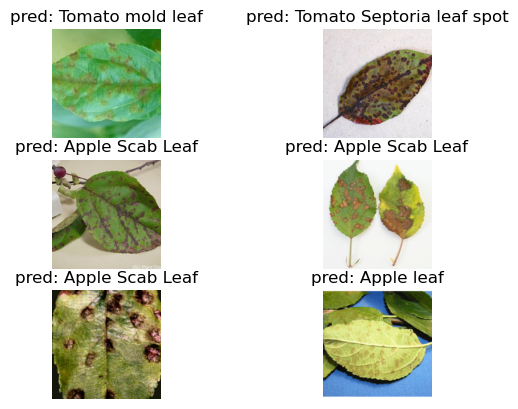

In [24]:
def visualize_model(model, dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'pred: {class_names[preds[j]]}')
                
                # Denormalize and show
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show()
                    return
    model.train(mode=was_training)

# Visualize
visualize_model(model, dataloaders['test'], class_names)
